## Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as ddf
import dask.multiprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

## データ読み込み

In [4]:
november = ddf.read_csv('../data/2019-Nov.csv', parse_dates=True)
november.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [5]:
october = ddf.read_csv('../data/2019-Oct.csv', parse_dates=True)
october.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## データ前処理
<ul>
    <li> 各データフレームのデータ数と欠損値を確認する
    <li> 各テーブルを結合するためにカラム名を調整する
    <li> 購入履歴テーブルにユーザ情報・商品情報テーブルを結合する
</ul>

### 各データフレームのデータ数と欠損値を確認する

In [6]:
print(f'length : {len(november)}')
print(f'columns : {november.columns}')
print(f'sum of num values in each column :')
print(november.isna().sum())

length : 67501979
columns : Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')
sum of num values in each column :
Dask Series Structure:
npartitions=1
brand           int64
user_session      ...
dtype: int64
Dask Name: dataframe-sum-agg, 433 tasks


In [7]:
print(f'length : {len(october)}')
print(f'columns : {october.columns}')
print(f'sum of num values in each column :')
print(october.isna().sum())

length : 42448764
columns : Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')
sum of num values in each column :
Dask Series Structure:
npartitions=1
brand           int64
user_session      ...
dtype: int64
Dask Name: dataframe-sum-agg, 274 tasks


### 2つのテーブルを結合する

In [19]:
# concat dataframes
purchase_history = ddf.concat([october, november])
purchase_history.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [9]:
print(f'length : {len(purchase_history)}')
print(f'unique user num : {len(purchase_history["user_id"].unique())}')
print(f'unique product num : {len(purchase_history["product_id"].unique())}')

length : 109950743
unique user num : 5316649
unique product num : 206876


### category_code, brandが欠損しているデータを除外する（レコメンド結果のわかりやすさのため）

In [20]:
purchase_history = purchase_history.dropna(subset=['brand', 'category_code'])
purchase_history.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880


In [23]:
# category_codeを分割
category_code = purchase_history['category_code'].str.split('.', expand=True, n=2)
purchase_history['category1'] = category_code[0]
purchase_history['category2'] = category_code[1]
purchase_history['category3'] = category_code[2]
purchase_history.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category1,category2,category3
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,environment,water_heater
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook,None
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone,None
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,desktop,None
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,apparel,shoes,keds


### データが多いので最初の10万件に絞る

In [24]:
recommendation_data = purchase_history.head(100000)
recommendation_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category1,category2,category3
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,environment,water_heater
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook,None
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone,None
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,computers,desktop,None
8,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,apparel,shoes,keds


In [14]:
print(f'sum of NaN values in each column : {recommendation_data.isna().sum()}')

sum of NaN values in each column : event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


## データ可視化

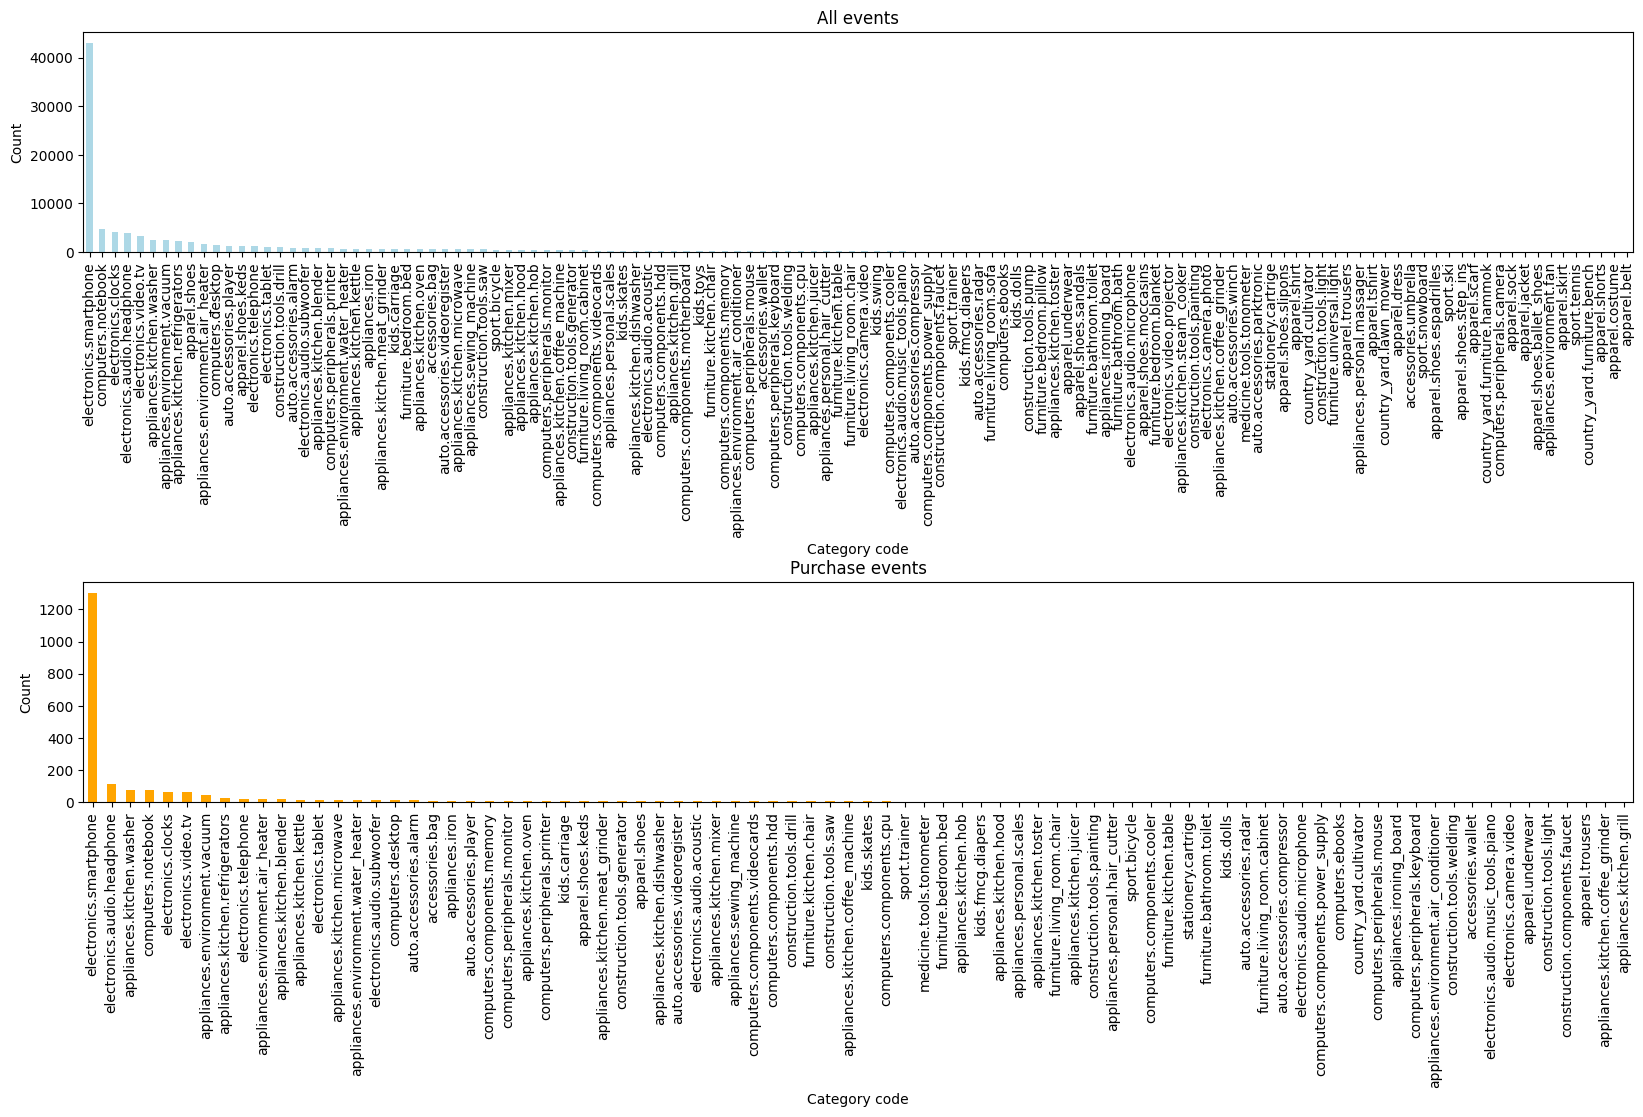

In [37]:
# すべてのevent_typeにおけるcategory_codeの集計と、購入のみのevemt_typeにおけるcategory_codeの集計を計算し、それぞれをヒストグラムとして、バーの色を変えすべてのラベルの間隔が十分に開くようにして、上下にプロットする
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
# グラフごとの上下の間隔を空ける
plt.subplots_adjust(hspace=1.5)
recommendation_data['category_code'].value_counts().plot(kind='bar', ax=ax[0], color='lightblue')
recommendation_data[recommendation_data['event_type'] == 'purchase']['category_code'].value_counts().plot(kind='bar', ax=ax[1], color='orange')
ax[0].set_title('All events')
ax[0].set_xlabel('Category code')
ax[1].set_title('Purchase events')
ax[1].set_xlabel('Category code')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.show()

In [38]:
# すべてのイベントにおけるcategory_codeの集計結果の上位10件と、購入のみのイベントにおけるcategory_codeの集計結果の上位10件をそれぞれ表示する
print(f'All events : {recommendation_data["category_code"].value_counts().head(10)}')
print(f'Purchase events : {recommendation_data[recommendation_data["event_type"] == "purchase"]["category_code"].value_counts().head(10)}')

All events : electronics.smartphone               43084
computers.notebook                    4760
electronics.clocks                    4114
electronics.audio.headphone           3996
electronics.video.tv                  3229
appliances.kitchen.washer             2523
appliances.environment.vacuum         2495
appliances.kitchen.refrigerators      2327
apparel.shoes                         2016
appliances.environment.air_heater     1723
Name: category_code, dtype: int64
Purchase events : electronics.smartphone               1305
electronics.audio.headphone           112
appliances.kitchen.washer              76
computers.notebook                     73
electronics.clocks                     62
electronics.video.tv                   62
appliances.environment.vacuum          47
appliances.kitchen.refrigerators       26
electronics.telephone                  18
appliances.environment.air_heater      18
Name: category_code, dtype: int64


# レコメンドアルゴリズム